# Exercise 1

## Fundamentals of Machine Learning

#### Author:    Benedetta Casavecchia, Greta Toni, Elias Olofsson

#### Version information:
        2020-11-20: v.1.0. First public release. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1.1 - Data creation and Visualization (7 pts)

In order to find the required transformation formulas, one can exploit the direct inversion method.
* #### p( X = x | Y = 0 )

\begin{eqnarray}
\int_{0}^{x}(2-2x')dx' &=& \int_{0}^{y}dy' \\
(2x'-x'^2)\biggr|_{0}^{x} &=& y'\biggr|_{0}^{y} \\
2x - x^2 &=& y
\end{eqnarray}

\begin{eqnarray}
\Rightarrow x &=& \frac{2 - \sqrt{4-4y}}{2} \\
&=& 1-\sqrt{1-y}
\end{eqnarray}

* #### p( X = x | Y = 1 )

\begin{eqnarray}
\int_{0}^{x}2x'dx' &=& \int_{0}^{y}dy' \\
x'^2\biggr|_{0}^{x} &=& y'\biggr|_{0}^{y} \\
x^2 &=& y
\end{eqnarray}

\begin{eqnarray}
\Rightarrow x &=& \sqrt{y}
\end{eqnarray}

where the signs of solutions are chosen to match with the given intervals.

Thus, the transformation functions implemented in the code are:
$$
\texttt{inversion$\_$y0} = 1-\sqrt{1-x} \\
\texttt{inversion$\_$y1} = \sqrt{x}
$$


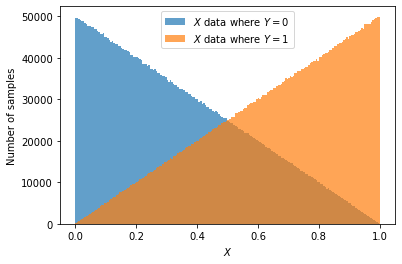

In [2]:
# Exact inversions to transform probability distributions. 
def inversion_y0(x):
    return 1-np.sqrt(1-x)
    
def inversion_y1(x):
    return np.sqrt(x)

# Generate N pairs of feature data X and labels Y.
def create_data(N):
    # Generate N random labels {0,1} with equal probability.
    y = np.random.randint(2, size=N)

    # For exercise 1.4, make sure that at least one instance of each class exists among the lables.
    if np.all(y == 0): 
        y[0] = 1                    # Introduce a single 1. 
        np.random.shuffle(y)        # Shuffle randomly.
    elif np.all(y == 1):    
        y[0] = 0                    # Introduce a single 0. 
        np.random.shuffle(y)        # Shuffle randomly.

    # Draw random numbers from the standard flat distribution on [0,1].
    x_rand = np.random.random(N)
    
    # Preallocate array for X data.
    x = np.zeros_like(x_rand)
    
    # Filter out values where Y == 0 or 1, and apply the corresponding analytical
    # probability inversion to transfer values into each new distribution.
    x[y==0] = inversion_y0(x_rand[y==0])
    x[y==1] = inversion_y1(x_rand[y==1])

    return np.concatenate([[x], [y]]).T

# Test that the create_data() function works correctly.
N = 10**7
data = create_data(N)
mask_y0 = data[:,1]==0
mask_y1 = data[:,1]==1
plt.hist(data[mask_y0,0], bins=200, alpha=0.7, label="$X$ data where $Y = 0$")
plt.hist(data[mask_y1,0], bins=200, alpha=0.7, label="$X$ data where $Y = 1$")
plt.legend()
plt.xlabel("$X$")
plt.ylabel("Number of samples")
plt.savefig("data_creation.pdf", format='pdf', bbox_inches='tight')

## Exercise 1.2 - Classification by Thresholding (5 pts)

Experimentally testing the predicted error rates for the set thresholds, sample sizes and classification rules. 
    
Currently averaging over 10 datasets for each sample size.


Rule A:
    Threshold: 0.2
        Sample size: 10
        Avg error rate: 0.31  , Std: 0.1136

        Sample size: 100
        Avg error rate: 0.363 , Std: 0.04605

        Sample size: 1000
        Avg error rate: 0.3379, Std: 0.01087

        Sample size: 10000
        Avg error rate: 0.3384, Std: 0.003405

    Threshold: 0.5
        Sample size: 10
        Avg error rate: 0.2   , Std: 0.1095

        Sample size: 100
        Avg error rate: 0.235 , Std: 0.03138

        Sample size: 1000
        Avg error rate: 0.2499, Std: 0.005804

        Sample size: 10000
        Avg error rate: 0.2489, Std: 0.005134

    Threshold: 0.6
        Sample size: 10
        Avg error rate: 0.22  , Std: 0.1166

        Sample size: 100
        Avg error rate: 0.271 , Std: 0.037 

        Sample size: 1000
        Avg error 

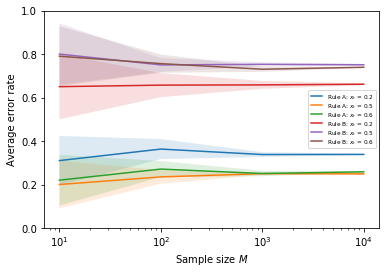

In [3]:
# Defining threshold classifiers A and B
def ruleA(x,t):
    predict = np.zeros_like(x)
    predict[x<t] = 0
    predict[x>=t] = 1
    return predict

def ruleB(x,t):
    return 1-ruleA(x,t)

# Calculate the error rate for the given data, classification rule and threshold.
def error_test(data,rulefunc,threshold):
    # Get the predicted responses Y from the X values in the data.
    y_predicted = rulefunc(data[:,0], threshold)

    # Compare preditions with the true data, calculate the error rate.
    correct_predictions =  sum(y_predicted == data[:,1])
    samplesize = np.size(data, axis=0)
    error_rate = 1 - correct_predictions/samplesize
    
    return error_rate

# Function to experimentally test a set of classification rules given sets of various parameters.
# M:            list of sample sizes, 
# N:            number of tests to perform at each sample size, 
# Thresholds:   list with thresholds to test, 
# rule_list:    list with function definitions to test, 
# filename:     string to specify name when saving the generated figure.
def exp_test(M,N,Thresholds,rule_list,filename):
    # Preallocations
    error = np.zeros(N)
    avg_err = np.zeros(len(M))
    std_err = np.zeros(len(M))

    print(f"""Experimentally testing the predicted error rates for the set thresholds, sample sizes and classification rules. 
    \nCurrently averaging over {N} datasets for each sample size.\n\n""")
    # Test each rule in list
    for rule_func in rule_list:
        fname = rule_func.__name__
        print(f"Rule {fname[-1]}:")
        
        # Test each threshold
        for xt in Thresholds:
            print(f"    Threshold: {xt}")
            
            # Test each sample size
            for i,m in enumerate(M):
                print(f"        Sample size: {m}")
                
                # Repeat test N times for each sample size
                for j in range(N):
                    data = create_data(m)
                    error[j] = error_test(data,rule_func,xt)
                
                avg_err[i] = np.average(error)
                std_err[i] = np.std(error)
                print(f"        Avg error rate: {avg_err[i]:<6.4}, Std: {std_err[i]:<6.4}\n")
            
            # Plot the average error, plus/minus one standard deviation of the error.
            plt.plot(M, avg_err, label=f"Rule {fname[-1]}: $x_t$ = {xt}")
            plt.fill_between(M, (avg_err-std_err), (avg_err+std_err), alpha=0.15)
            # Settings and labeling
            plt.xscale('log')
            if (fname[-1] == 'A') or (fname[-1] == 'B'):
                locstr = 'center right'
            else:
                locstr = 'best'
            plt.legend(loc=f'{locstr}',fontsize='xx-small', labelspacing=0.01)
            plt.xlabel('Sample size $M$')
            plt.ylabel('Average error rate')
            plt.ylim((0,1))
    # Saving the figure
    plt.savefig(f"{filename}.pdf", format='pdf', bbox_inches='tight')


# Settings
M = [10, 100, 1000, 10000]      # Sample sizes
N = 10                          # No. of tests per sample size.
Thresholds = [0.2, 0.5, 0.6]    # Thresholds to test.
rule_list = [ruleA, ruleB]      # Specifiy the rules to use.

# Execute the test
exp_test(M,N,Thresholds,rule_list,'avg_error_ruleAB')


## Exercise 1.3 - Baseline Classifiers (2 pts)

Experimentally testing the predicted error rates for the set thresholds, sample sizes and classification rules. 
    
Currently averaging over 10 datasets for each sample size.


Rule C:
    Threshold: None
        Sample size: 10
        Avg error rate: 0.51  , Std: 0.09434

        Sample size: 100
        Avg error rate: 0.465 , Std: 0.03667

        Sample size: 1000
        Avg error rate: 0.4939, Std: 0.01968

        Sample size: 10000
        Avg error rate: 0.5021, Std: 0.004682

Rule D:
    Threshold: None
        Sample size: 10
        Avg error rate: 0.5   , Std: 0.08944

        Sample size: 100
        Avg error rate: 0.483 , Std: 0.0546

        Sample size: 1000
        Avg error rate: 0.5024, Std: 0.01769

        Sample size: 10000
        Avg error rate: 0.5011, Std: 0.00847



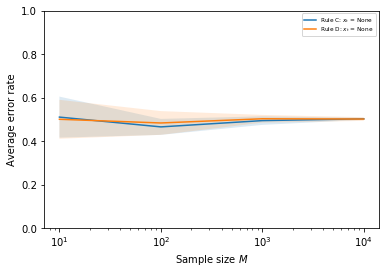

In [4]:
# Pure guessing Y = {0,1} with equal probability.
def ruleC(x, threshold):
    predict = np.random.randint(2, size=x.shape)
    return predict

# Always selecting the predictor Y = 1.
def ruleD(x, threshold):
    predict = np.ones(x.shape)
    return predict

# Settings
M = [10, 100, 1000, 10000]  # Sample sizes
N = 10                      # No. of tests per sample size.
Thresholds = [None]         # Thresholds to test. (Not utilized for Rule C and D)
rule_list = [ruleC, ruleD]  # Specifiy the rules to use.

# Executing the test
exp_test(M,N,Thresholds,rule_list, 'avg_error_ruleCD')

## Exercise 1.4 - Nearest Neighbour Classification (6 pts)

In [5]:
# Train a Nearest Neighbour classifer using data in a Training Set (TS), output 
# the predicted responses Y for the feature data X (x_data) using the trained 
# NN classifier. 
def nn_classifier(TS, x_data):
    # Separate the features from the responses in the Training Set.
    x_TS = TS[:,0]
    y_TS = TS[:,1]

    # Calculate distance from every feature in the x_data to all features in the TS.
    distance = np.abs(x_TS[:,None] - x_data)
    
    # Find indicies in TS, for which the distance d(x_TS[i],x_data[j]) is minimal. 
    i_min = np.argmin(distance, axis=0)     

    # Use indicies to find the Y labels of the nearest neighbours.
    y_prediction = y_TS[i_min]
    
    return y_prediction

# Test a NN classifier trained with a randomly generated training set of size N.
# Comparsion is made with a supplied Out of Training Set (OTS) and the error 
# rate is returned.  
def test_nn(N,OTS):
    # Create a new Training Set 
    TS = create_data(N)

    # Split the Out of Training Set data into two vectors.  
    x_OTS = OTS[:,0]
    y_OTS = OTS[:,1]
    
    # Tot number of (X,Y) pairs in the OTS. 
    OTS_length = len(x_OTS)  

    # Predict labels using the X data in the OTS.
    y_prediction = nn_classifier(TS,x_OTS)

    # Compare prediction from NN classifier with the Y data in the OTS and 
    # estimate the error.
    correct_pred = sum(y_OTS == y_prediction)
    error = 1 - correct_pred/OTS_length

    return error

# Perform multiple tests of a NN classifier trained with different training sets.
# Need to specify the size (N) of each randomly generated training set, the size 
# (M) of the Out of Training Set used for validiation, and the number of tests 
# (no_tests) that shall be performed. Return the average error rate. 
def multi_test(N,M,no_tests):
    # Generate the test set used for validation of the NN classifier.
    OTS = create_data(M)

    error = np.zeros(no_tests)  # Preallocation
    
    # For the set amount of times, compare a newly generated Training Set of 
    # size N against the same Out of Training Set with size M from above. 
    for i in range(no_tests):
        error[i] = test_nn(N,OTS)

    avg_error = np.average(error)

    return avg_error


# Settings
N = [2, 100]        # Size of the training set.
M = 10**4           # Size of the test set.
no_tests = 100      # Number of tests to perform.

for i in N:
    avg_err = multi_test(2,M,no_tests)
    print(f"For NN classifier, Training set size N = {i}, Test set size M = {M}"
          f", {no_tests} tests performed, Average error rate: {avg_err}.\n")


For NN classifier, Training set size N = 2, Test set size M = 10000, 100 tests performed, Average error rate: 0.3361050000000001.

For NN classifier, Training set size N = 100, Test set size M = 10000, 100 tests performed, Average error rate: 0.34454799999999997.

